# Sử dụng mô hình SVR dự báo nhiệt độ trung bình London

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cài đặt cho đồ thị đẹp hơn
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
# Tải dữ liệu từ file CSV
df = pd.read_csv('london_weather.csv')

# Hiển thị 5 dòng đầu tiên để xem cấu trúc dữ liệu
print("5 dòng dữ liệu đầu tiên:")
print(df.head())
print("\n" + "="*50 + "\n")

# Hiển thị thông tin tổng quan về DataFrame
print("Thông tin chung về dữ liệu:")
df.info()
print("\n" + "="*50 + "\n")

# Hiển thị thống kê mô tả cho các cột số
print("Thống kê mô tả:")
print(df.describe())

5 dòng dữ liệu đầu tiên:
       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  


Thông tin chung về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------         

In [3]:
# Lặp qua từng cột để điền giá trị thiếu bằng giá trị trung bình của cột đó
for col in df.columns:
    if df[col].isnull().any():
        # Chỉ điền cho các cột dạng số
        if pd.api.types.is_numeric_dtype(df[col]):
            mean_value = df[col].mean()
            df[col].fillna(mean_value, inplace=True)
            print(f"Đã điền các giá trị thiếu trong cột '{col}' bằng giá trị trung bình: {mean_value:.2f}")

# Kiểm tra lại xem còn giá trị thiếu không
print("\nKiểm tra lại sau khi xử lý giá trị thiếu:")
print(df.isnull().sum())

Đã điền các giá trị thiếu trong cột 'cloud_cover' bằng giá trị trung bình: 5.27
Đã điền các giá trị thiếu trong cột 'global_radiation' bằng giá trị trung bình: 118.76
Đã điền các giá trị thiếu trong cột 'max_temp' bằng giá trị trung bình: 15.39
Đã điền các giá trị thiếu trong cột 'mean_temp' bằng giá trị trung bình: 11.48
Đã điền các giá trị thiếu trong cột 'min_temp' bằng giá trị trung bình: 7.56
Đã điền các giá trị thiếu trong cột 'precipitation' bằng giá trị trung bình: 1.67
Đã điền các giá trị thiếu trong cột 'pressure' bằng giá trị trung bình: 101536.61
Đã điền các giá trị thiếu trong cột 'snow_depth' bằng giá trị trung bình: 0.04

Kiểm tra lại sau khi xử lý giá trị thiếu:
date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10932\4159647073.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [4]:
# Chuyển cột 'date' sang định dạng datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Sắp xếp DataFrame theo ngày tháng để đảm bảo tính tuần tự của chuỗi thời gian
df = df.sort_values(by='date').reset_index(drop=True)

# Đặt cột 'date' làm chỉ số (index) của DataFrame
df.set_index('date', inplace=True)

print("\nDataFrame sau khi xử lý ngày tháng và đặt làm index:")
print(df.head())


DataFrame sau khi xử lý ngày tháng và đặt làm index:
            cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
date                                                                       
1979-01-01          2.0       7.0              52.0       2.3       -4.1   
1979-01-02          6.0       1.7              27.0       1.6       -2.6   
1979-01-03          5.0       0.0              13.0       1.3       -2.8   
1979-01-04          8.0       0.0              13.0      -0.3       -2.6   
1979-01-05          6.0       2.0              29.0       5.6       -0.8   

            min_temp  precipitation  pressure  snow_depth  
date                                                       
1979-01-01      -7.5            0.4  101900.0         9.0  
1979-01-02      -7.5            0.0  102530.0         8.0  
1979-01-03      -7.2            0.0  102050.0         4.0  
1979-01-04      -6.5            0.0  100840.0         2.0  
1979-01-05      -1.4            0.0  102250.0        

In [5]:
# Tạo các đặc trưng trễ (lag features) cho các biến quan trọng
# Chúng ta sẽ sử dụng dữ liệu của ngày hôm trước để dự đoán ngày hôm nay
lag_features = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
n_lags = 1 # Sử dụng dữ liệu của 1 ngày trước

for feature in lag_features:
    df[f'{feature}_lag_{n_lags}'] = df[feature].shift(n_lags)

# Xóa các dòng có giá trị NaN do phép dịch chuyển (dòng đầu tiên)
df.dropna(inplace=True)

print("\nDataFrame sau khi tạo đặc trưng trễ:")
print(df.head())


DataFrame sau khi tạo đặc trưng trễ:
            cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
date                                                                       
1979-01-02          6.0       1.7              27.0       1.6       -2.6   
1979-01-03          5.0       0.0              13.0       1.3       -2.8   
1979-01-04          8.0       0.0              13.0      -0.3       -2.6   
1979-01-05          6.0       2.0              29.0       5.6       -0.8   
1979-01-06          5.0       3.8              39.0       8.3       -0.5   

            min_temp  precipitation  pressure  snow_depth  cloud_cover_lag_1  \
date                                                                           
1979-01-02      -7.5            0.0  102530.0         8.0                2.0   
1979-01-03      -7.2            0.0  102050.0         4.0                6.0   
1979-01-04      -6.5            0.0  100840.0         2.0                5.0   
1979-01-05      -1.4         

In [6]:
# Biến mục tiêu là nhiệt độ trung bình 'mean_temp'
y = df['mean_temp']

# Các đặc trưng là tất cả các cột còn lại (bao gồm cả các cột lag vừa tạo)
# Chúng ta loại bỏ các cột gốc không phải lag vì chúng là thông tin của ngày hiện tại, không thể dùng để dự đoán chính nó.
X = df.drop(columns=lag_features) # Bỏ các cột gốc, chỉ giữ lại các cột lag

print("\nCác đặc trưng (X) - 5 dòng đầu:")
print(X.head())
print("\nBiến mục tiêu (y) - 5 giá trị đầu:")
print(y.head())


Các đặc trưng (X) - 5 dòng đầu:
            cloud_cover_lag_1  sunshine_lag_1  global_radiation_lag_1  \
date                                                                    
1979-01-02                2.0             7.0                    52.0   
1979-01-03                6.0             1.7                    27.0   
1979-01-04                5.0             0.0                    13.0   
1979-01-05                8.0             0.0                    13.0   
1979-01-06                6.0             2.0                    29.0   

            max_temp_lag_1  mean_temp_lag_1  min_temp_lag_1  \
date                                                          
1979-01-02             2.3             -4.1            -7.5   
1979-01-03             1.6             -2.6            -7.5   
1979-01-04             1.3             -2.8            -7.2   
1979-01-05            -0.3             -2.6            -6.5   
1979-01-06             5.6             -0.8            -1.4   

            p

In [7]:
# Chia dữ liệu: 80% cho huấn luyện, 20% cho kiểm tra
split_point = int(len(X) * 0.8)

X_train = X[:split_point]
y_train = y[:split_point]

X_test = X[split_point:]
y_test = y[split_point:]

print(f"\nKích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")


Kích thước tập huấn luyện: (12272, 9)
Kích thước tập kiểm tra: (3068, 9)


In [8]:
# Khởi tạo Scaler
scaler = StandardScaler()

# Fit và transform trên tập huấn luyện
X_train_scaled = scaler.fit_transform(X_train)

# Chỉ transform trên tập kiểm tra (dùng tham số học từ tập train)
X_test_scaled = scaler.transform(X_test)

print("\nĐã chuẩn hóa dữ liệu.")


Đã chuẩn hóa dữ liệu.


In [9]:
# Khởi tạo mô hình SVR
# kernel='rbf': Kernel phi tuyến tính, rất mạnh mẽ.
# C: Tham số điều chuẩn (Regularization parameter). Giá trị lớn hơn nghĩa là phạt nặng hơn cho lỗi.
# epsilon: Xác định vùng "không phạt lỗi". Các điểm dữ liệu nằm trong khoảng epsilon so với dự đoán sẽ không bị tính lỗi.
svr_model = SVR(kernel='rbf', C=10, epsilon=0.1)

# Huấn luyện mô hình
print("Bắt đầu huấn luyện mô hình SVR...")
svr_model.fit(X_train_scaled, y_train)
print("Huấn luyện hoàn tất!")

Bắt đầu huấn luyện mô hình SVR...


Huấn luyện hoàn tất!


In [10]:
# Dự đoán trên tập kiểm tra
y_pred = svr_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = safe_mape(y_test, y_pred)
print("MAPE:", round(mape, 2), "%")
print("\n--- Kết quả đánh giá mô hình ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} (Sai số tuyệt đối trung bình là {mae:.2f} độ C)")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f} (Mô hình giải thích được {r2*100:.2f}% phương sai của dữ liệu)")

MAPE: 11.29 %

--- Kết quả đánh giá mô hình ---
Mean Absolute Error (MAE): 0.90 (Sai số tuyệt đối trung bình là 0.90 độ C)
Mean Squared Error (MSE): 1.81
R-squared (R²): 0.94 (Mô hình giải thích được 94.36% phương sai của dữ liệu)


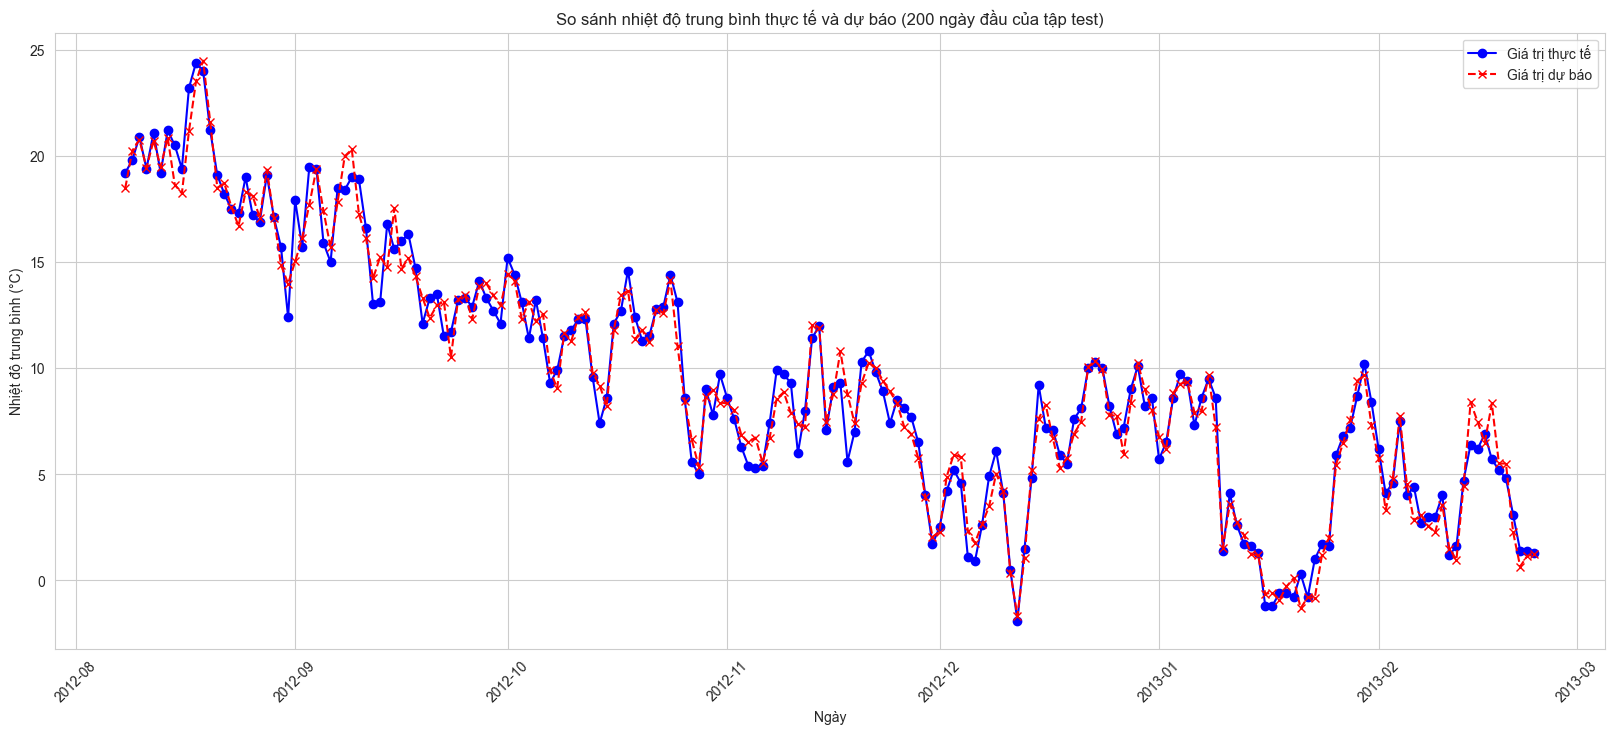

In [11]:
# Tạo một DataFrame để dễ dàng vẽ đồ thị
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Vẽ đồ thị so sánh cho 200 điểm dữ liệu đầu tiên của tập test
plt.figure(figsize=(20, 8))
plt.plot(results_df.index[:200], results_df['Actual'][:200], label='Giá trị thực tế', color='blue', marker='o', linestyle='-')
plt.plot(results_df.index[:200], results_df['Predicted'][:200], label='Giá trị dự báo', color='red', marker='x', linestyle='--')
plt.title('So sánh nhiệt độ trung bình thực tế và dự báo (200 ngày đầu của tập test)')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ trung bình (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.show()